## Simplest $\Delta G'^\circ$ example

In [1]:
import equilibrator_api
reaction = equilibrator_api.parse_reaction_formula("kegg:C00002 + kegg:C00001 = kegg:C00008 + kegg:C00009")
cc = equilibrator_api.ComponentContribution()
dG0_prime = cc.standard_dg_prime(reaction)
print(f"ΔG'° = {dG0_prime}")

Fragments already downloaded


Exporting file 2 of 2 [00:00]: compounds.sqlite


Fragments already downloaded
ΔG'° = (-25.77 +/- 0.31) kilojoule / mole


## Basic $\Delta G'$ calculations

In [2]:
from equilibrator_api import Q_
reaction = equilibrator_api.parse_reaction_formula("kegg:C00002 + kegg:C00001 = kegg:C00008 + kegg:C00009")
cc = equilibrator_api.ComponentContribution(p_h=Q_(7.0), ionic_strength=Q_("0.25M"), temperature=Q_("298.15K"))

dG0_prime = cc.standard_dg_prime(reaction)
print(f"ΔG'° = {dG0_prime}")

dGm_prime = cc.physiological_dg_prime(reaction)
print(f"ΔG'm = {dGm_prime}")

concentrations = [('kegg:C00002', 1.0),
                  ('kegg:C00009', 0.1),
                  ('kegg:C00008', 3.0)]
for cid, conc in concentrations:
    compound = equilibrator_api.ccache.get_compound(cid)
    abundance = Q_(conc, "mM")
    reaction.set_abundance(compound, abundance)

dG_prime = cc.dg_prime(reaction)
print(f"ΔG' = {dG_prime}")

ΔG'° = (-25.77 +/- 0.31) kilojoule / mole
ΔG'm = (-42.89 +/- 0.31) kilojoule / mole
ΔG' = (-45.87 +/- 0.31) kilojoule / mole


## Max-min Driving Force (MDF) example

In [3]:
import numpy

p_h = Q_("7.0")
temperature = Q_("298.15K")
ionic_strength = Q_("0.25M")
reactions = ['kegg:C00092 + kegg:C00006 <=> kegg:C01236 + kegg:C00005',
             'kegg:C01236 + kegg:C00001 <=> kegg:C00345',
             'kegg:C00345 + kegg:C00006 <=> kegg:C00199 + kegg:C00011 + kegg:C00005']
reactions = list(map(equilibrator_api.parse_reaction_formula, reactions))
fluxes = numpy.ones(3)
bounds = equilibrator_api.Bounds(default_lb=Q_("100 uM"), default_ub=Q_("10 mM"))
pp = equilibrator_api.Pathway(reactions, fluxes, bounds=bounds,
                              p_h=p_h, ionic_strength=ionic_strength, temperature=temperature)

mdf_data = pp.calc_mdf()
print(f"MDF = {mdf_data.mdf:.2f}")
mdf_data.compound_df

MDF = 19.59 kilojoule / mole


compound  \
0  Compound(id=5, inchi_key=XLYOFNOQVPJJNP-UHFFFA...   
1  Compound(id=8, inchi_key=XJLXINKUBYWONI-NNYOXO...   
2  Compound(id=9, inchi_key=ACFIXJIJDZMPPO-NNYOXO...   
3  Compound(id=16, inchi_key=CURLTUGMZLYLDI-UHFFF...   
4  Compound(id=137, inchi_key=FNZLKVNUWIIPSJ-UHNV...   
5  Compound(id=152, inchi_key=NBSCHQHZLSJFNQ-GASJ...   
6  Compound(id=307, inchi_key=BIRSGZKFKXLSJQ-SQOU...   
7  Compound(id=408, inchi_key=IJOJIVNDFQSGAB-SQOU...   

                 concentration  shadow_price     lower_bound    upper_bound  
0   0.010000000000000004 molar  5.000000e-01  100 micromolar  10 millimolar  
1   0.010000000000000014 molar  5.000000e-01  100 micromolar  10 millimolar  
2  9.999999999999991e-05 molar -5.000000e-01  100 micromolar  10 millimolar  
3  0.0001307166333279756 molar  3.854339e-18  100 micromolar  10 millimolar  
4  9.999999999999973e-05 molar  3.854339e-18  100 micromolar  10 millimolar  
5   0.010000000000000014 molar  5.000000e-01  100 micromolar  10 millimolar  
6  9.999999999999991e-05 molar -5.000000e-01  100 micromolar  10 millimolar  
7  0.0022821877710016043 molar  0.000000e+00  100 micromolar  10 millimolar

/mnt/a0d03c98-5e23-4d9b-b2ac-6312c7f230d5/virtualenvironment/eq_api/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


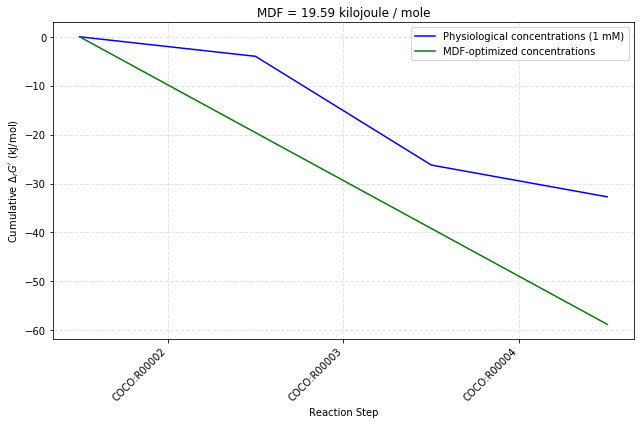

In [4]:
fig1 = mdf_data.reaction_plot
fig1.show()

/mnt/a0d03c98-5e23-4d9b-b2ac-6312c7f230d5/virtualenvironment/eq_api/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


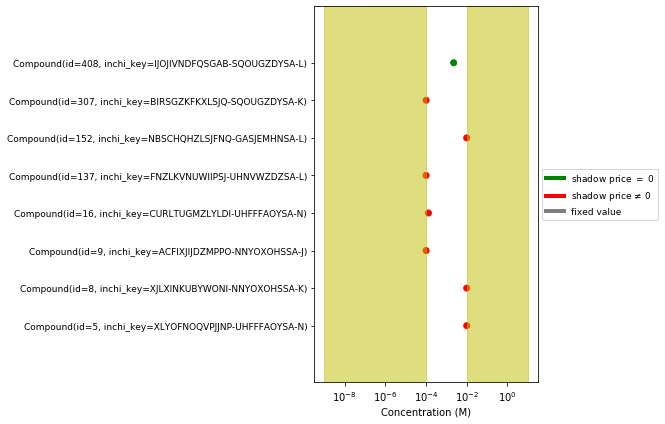

In [5]:
fig2 = mdf_data.compound_plot
fig2.show()

## Reaction matching and $\Delta G'^\circ$ estimation

The reaction matching code is currently not working, and many of the functions need to be reimplemented
after the transition to the new equilibrator-cache.

```
import argparse
from equilibrator_api.pathway import Pathway
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib inline
```

The ± range represents the 95% confidence interval due to Component Contribution estimation uncertainty

```
reaction_matcher = ReactionMatcher()

def estimate_dG0(plaintext, pH=7.0, I=0.1):
    # parse the reaction
    try:
        reaction = reaction_matcher.match(plaintext)
    except ParseError:
        print('incomplete formula')
        return
    except ValueError as e:
        print(e)
        return

    html = '<p>pH = %.2f, I = %.2f M</br>KEGG reaction: %s</br></p>' % (pH, I, reaction.write_formula())
    
    equilibrator = ComponentContribution(pH=pH, ionic_strength=I)
    
    n_e = reaction.check_half_reaction_balancing()
    if n_e is None:
        html += '<p>ERROR: reaction is not chemically balanced</p>'
    elif n_e == 0:
        dG0_prime, dG0_uncertainty = equilibrator.dG0_prime(reaction)
        html += "<h2>\u0394G\'\u00B0 = %.2f \u00B1 %.2f kJ/mol</h2>" % (dG0_prime, 1.96 * dG0_uncertainty)
        ln_RI = equilibrator.reversibility_index(reaction)
        html += '<p>ln(Reversibility Index) = %.1f</p>' % ln_RI

    else:  # treat as a half-reaction
        E0_prime_mV, E0_uncertainty = equilibrator.E0_prime(reaction)
        html += '<h2>E\'\u00B0 = %.1f \u00B1 %.1f mV</h2>' % (E0_prime_mV, E0_uncertainty)

    w = widgets.HTML(html)
    display(w)
```

```
interact(estimate_dG0,
         plaintext=widgets.Text(value='glucose = fructose', font_size=20),
         pH=widgets.FloatSlider(min=0,max=14,step=0.25,value=7),
         I=widgets.FloatSlider(min=0,max=0.5,step=0.02,value=0.1));
```

The ± range represents the 95% confidence interval due to Component Contribution estimation uncertainty

## Single metabolite search

```
compound_matcher = CompoundMatcher()
df = compound_matcher.compound_df

df[df.CID == 'C00031']

def get_closest_matches(plaintext):
    # find matching compound names
    matches = compound_matcher.match(plaintext)
    
    print(matches)
    

get_closest_matches('beta-D-glucose')

matches = compound_matcher.match('beta-D-glucose')


matches.sort_values('score')
```